In [1]:
#importing all the libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import os
import torchvision.transforms as transforms
from torchvision import datasets,models
from tqdm import tqdm
from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

In [2]:
#My own implementation of the Dataset class
class IndexedDataset(Dataset):

    def __init__(self, dir_path):
        self.dir_path = dir_path
        
        if os.path.basename(self.dir_path) == 'train': #transforms for the train dataset
          self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        ])
        elif os.path.basename(self.dir_path) == 'test': #transforms for the test dataset
          self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        ])
        
        image_filenames = []
        for (dirpath, dirnames, filenames) in os.walk(dir_path): #Saving all the image locations
            image_filenames += [os.path.join(dirpath, file) for file in filenames]
        self.image_filenames = image_filenames    
        self.labels_map = {"airplane" : 0, "bus": 1, "cat" : 2, "dog" : 3, "pizza" : 4} #Creating hashmap of the class and a number

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx] #Reading the image
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        return image, self.labels_map[os.path.basename(os.path.dirname(img_name))]


In [3]:
#The first model as given in the Homework
class HW4Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3)
        self.fc1 = nn.Linear(6272,64)
        self.fc2 = nn.Linear(64,5)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    


In [4]:
#The second model as given in the Homework
class HW4Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.fc1 = nn.Linear(8192,64)
        self.fc2 = nn.Linear(64,5)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    


In [5]:
#The third model as given in the Homework
class HW4Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,32,3,padding=1)
        self.conv4 = nn.Conv2d(32,32,3,padding=1)
        self.conv5 = nn.Conv2d(32,32,3,padding=1)
        self.conv6 = nn.Conv2d(32,32,3,padding=1)
        self.conv7 = nn.Conv2d(32,32,3,padding=1)
        self.conv8 = nn.Conv2d(32,32,3,padding=1)
        self.conv9 = nn.Conv2d(32,32,3,padding=1)
        self.conv10 = nn.Conv2d(32,32,3,padding=1)
        self.conv11 = nn.Conv2d(32,32,3,padding=1)
        self.conv12 = nn.Conv2d(32,32,3,padding=1)
        self.fc1 = nn.Linear(8192,64)
        self.fc2 = nn.Linear(64,5)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    


In [6]:
#Function to train the models. Taken from the Homework
def training(epochs,optimizer,criterion,net,train_data_loader,device):
  train_losses = []
  for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_data_loader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.cpu().item()
      if (i + 1) % 100 == 0:
        print("[epoch: %d, batch: %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss/(i+1)))
    train_losses.append(running_loss/len(train_dataset)) #Storing the loss per image for every epoch
  return net, train_losses

In [7]:
#Function to compute the confusion matrix
def confusion_matrix(model,test_data_loader):
  matrix = torch.zeros((5,5))
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_data_loader):
      model.eval()                
      X_test, y_test = X_test.to(device), y_test.to(device)                
      # Apply the model                
      y_val = model(X_test)           
               
      # Tally the number of correct predictions
      predicted = torch.max(y_val.data, 1)[1] 
      for i in range(len(predicted)):
        matrix[predicted[i].cpu(),y_test[i].cpu()] += 1

  heat = pd.DataFrame(matrix, index = [i for i in ["airplane","bus","cat","dog","pizza"]],
                  columns = [i for i in ["airplane","bus","cat","dog","pizza"]])
  heat = heat.astype(int)
  accuracy = (matrix.trace()/matrix.sum())*100
  plt.figure(figsize = (10,7))
  plt.title("Total accuracy is "+str(accuracy.item()))
  sn.heatmap(heat, annot=True,cmap='Blues',fmt='g')
  
                


In [8]:
#Using the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
#Loading the dataset into the dataloader
train_dataset = IndexedDataset("/content/drive/MyDrive/Dataset_HW4/train")
test_dataset = IndexedDataset("/content/drive/MyDrive/Dataset_HW4/test")
train_data_loader = DataLoader(train_dataset,batch_size=32, shuffle=True,num_workers=32)
test_data_loader = DataLoader(test_dataset,batch_size=32, shuffle=True,num_workers=32)

#Defining the loss function and the number of epochs
criterion = nn.CrossEntropyLoss()
epochs = 10

#Creating an instance of the models and their respective optimizers
model1 = HW4Net1().to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001, betas = (0.9,0.99))

model2 = HW4Net2().to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001, betas = (0.9,0.99))

model3 = HW4Net3().to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001, betas = (0.9,0.99))


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
#Checking whether the train and test datasets are of the correct size
print(len(train_dataset))
print(len(test_dataset))

7500
2500


[epoch: 1, batch:   100] loss: 1.252
[epoch: 1, batch:   200] loss: 1.189
[epoch: 2, batch:   100] loss: 0.993
[epoch: 2, batch:   200] loss: 0.974
[epoch: 3, batch:   100] loss: 0.884
[epoch: 3, batch:   200] loss: 0.880
[epoch: 4, batch:   100] loss: 0.798
[epoch: 4, batch:   200] loss: 0.793
[epoch: 5, batch:   100] loss: 0.735
[epoch: 5, batch:   200] loss: 0.723
[epoch: 6, batch:   100] loss: 0.607
[epoch: 6, batch:   200] loss: 0.630
[epoch: 7, batch:   100] loss: 0.503
[epoch: 7, batch:   200] loss: 0.529
[epoch: 8, batch:   100] loss: 0.425
[epoch: 8, batch:   200] loss: 0.438
[epoch: 9, batch:   100] loss: 0.341
[epoch: 9, batch:   200] loss: 0.354
[epoch: 10, batch:   100] loss: 0.262
[epoch: 10, batch:   200] loss: 0.272


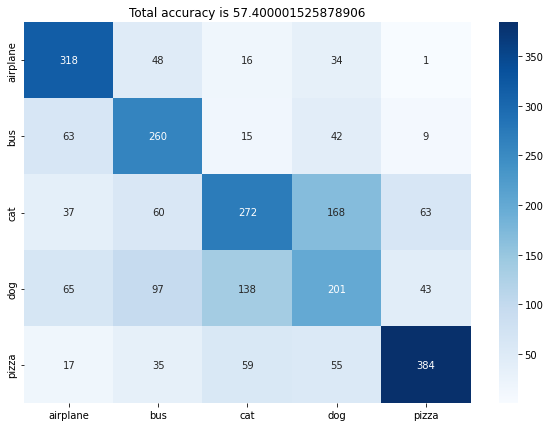

In [11]:
#Training the first model and plotting its confusion matrix
trained_model1,train_losses1 = training(epochs,optimizer1,criterion,model1,train_data_loader,device)
confusion_matrix(trained_model1,test_data_loader) 

[epoch: 1, batch:   100] loss: 1.243
[epoch: 1, batch:   200] loss: 1.167
[epoch: 2, batch:   100] loss: 0.975
[epoch: 2, batch:   200] loss: 0.973
[epoch: 3, batch:   100] loss: 0.907
[epoch: 3, batch:   200] loss: 0.881
[epoch: 4, batch:   100] loss: 0.787
[epoch: 4, batch:   200] loss: 0.781
[epoch: 5, batch:   100] loss: 0.666
[epoch: 5, batch:   200] loss: 0.674
[epoch: 6, batch:   100] loss: 0.552
[epoch: 6, batch:   200] loss: 0.553
[epoch: 7, batch:   100] loss: 0.431
[epoch: 7, batch:   200] loss: 0.443
[epoch: 8, batch:   100] loss: 0.305
[epoch: 8, batch:   200] loss: 0.328
[epoch: 9, batch:   100] loss: 0.219
[epoch: 9, batch:   200] loss: 0.243
[epoch: 10, batch:   100] loss: 0.169
[epoch: 10, batch:   200] loss: 0.178


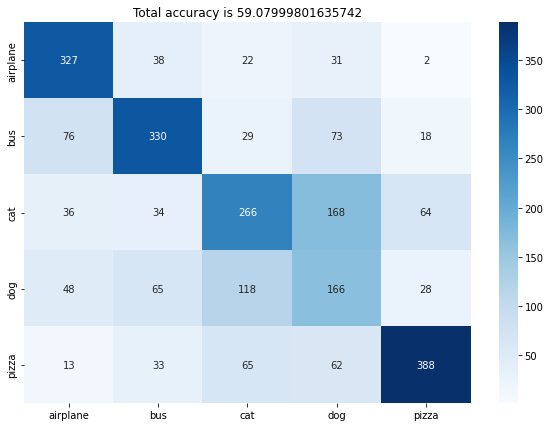

In [12]:
#Training the second model and plotting its confusion matrix
trained_model2,train_losses2 = training(epochs,optimizer2,criterion,model2,train_data_loader,device)
confusion_matrix(trained_model2,test_data_loader) 

[epoch: 1, batch:   100] loss: 1.508
[epoch: 1, batch:   200] loss: 1.416
[epoch: 2, batch:   100] loss: 1.224
[epoch: 2, batch:   200] loss: 1.242
[epoch: 3, batch:   100] loss: 1.202
[epoch: 3, batch:   200] loss: 1.206
[epoch: 4, batch:   100] loss: 1.160
[epoch: 4, batch:   200] loss: 1.135
[epoch: 5, batch:   100] loss: 1.104
[epoch: 5, batch:   200] loss: 1.106
[epoch: 6, batch:   100] loss: 1.034
[epoch: 6, batch:   200] loss: 1.027
[epoch: 7, batch:   100] loss: 1.009
[epoch: 7, batch:   200] loss: 0.991
[epoch: 8, batch:   100] loss: 0.948
[epoch: 8, batch:   200] loss: 0.959
[epoch: 9, batch:   100] loss: 0.912
[epoch: 9, batch:   200] loss: 0.911
[epoch: 10, batch:   100] loss: 0.886
[epoch: 10, batch:   200] loss: 0.885


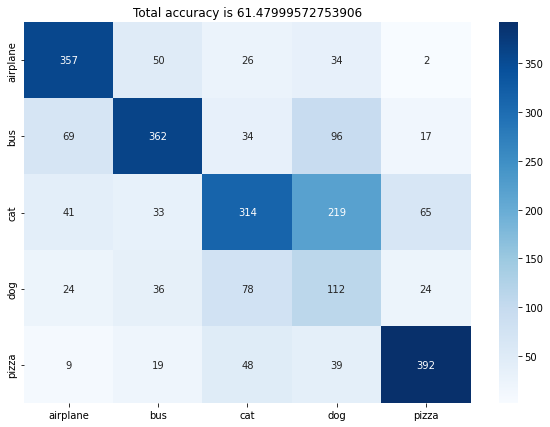

In [19]:
#Training the third model and plotting its confusion matrix
trained_model3,train_losses3 = training(epochs,optimizer3,criterion,model3,train_data_loader,device)
confusion_matrix(trained_model3,test_data_loader) 

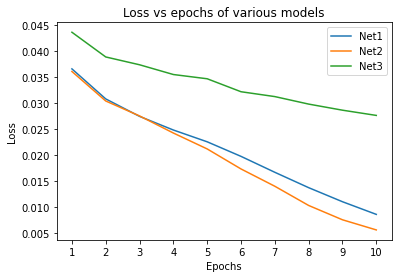

In [20]:
#Plotting the training loss vs epochs for all the three models
epochs = np.arange(1,11)
plt.xticks(epochs, epochs)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs epochs of various models")
plt.plot(epochs,train_losses1,label="Net1")
plt.plot(epochs,train_losses2,label="Net2")
plt.plot(epochs,train_losses3,label="Net3")
plt.legend(loc = "upper right")
